# Personal data

Name: Alexander Huber  
Nationality: Austria  
Date of birth: 25.07.1998  
Phone number: +43 660 6209202  
University mail adress: e11714016@student.tuwien.ac.at  
University: University of Technology Vienna

# Structure of the analysis

In section A of the Jupyter Notebook, the focus is on reading the data from the various data sources described in appendix B of the pdf document and transforming it. Data transformation is a crucial part of the data mash up because data sets provided on the internet as .txt or .csv or .xlsx files are often in a format that makes it difficult to work with them decently in R. Therefore it is important to get the data into a proper structure in order to work with it properly in the analysis part.    
In section B of the Jupyter Notebook analyses of the data are performed and graphs are produced in order to illustrate the analyses. In the first part of the analyses, the focus is on the Austrian insurance industry, with a distinction being made here between the segments "Life", "Health" and "Non-Life".  
In the second part, selected EU countries are examined in more detail and comparisons are made.

In [1]:
install.packages("data.table", dependencies = TRUE)
library(data.table)

install.packages("readr", dependencies = TRUE)
library(readr)

install.packages("ggplot2", dependencies = TRUE)
library(ggplot2)

install.packages("readxl", dependencies = TRUE)
library(readxl)

install.packages("vctrs", dependencies = TRUE)
library(vctrs)

# delete the workspace
rm(list = ls())


# option to supress the message "column specification" when reading .csv files with read_csv
options(readr.num_columns = 0)

package 'data.table' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\alexh\AppData\Local\Temp\RtmpUBk7BV\downloaded_packages


Warning message:
"package 'data.table' was built under R version 3.6.3"

package 'readr' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\alexh\AppData\Local\Temp\RtmpUBk7BV\downloaded_packages


Warning message:
"package 'readr' was built under R version 3.6.3"Registered S3 methods overwritten by 'tibble':
  method     from  
  format.tbl pillar
  print.tbl  pillar


package 'ggplot2' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\alexh\AppData\Local\Temp\RtmpUBk7BV\downloaded_packages


Warning message:
"package 'ggplot2' was built under R version 3.6.3"

package 'readxl' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\alexh\AppData\Local\Temp\RtmpUBk7BV\downloaded_packages


Warning message:
"package 'readxl' was built under R version 3.6.3"also installing the dependencies 'glue', 'tibble', 'tidyselect', 'dplyr'




  There is a binary version available but the source version is later:
       binary source needs_compilation
tibble  3.1.1  3.1.2              TRUE

package 'glue' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'glue'"Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"Problem C:\Users\alexh\anaconda3\envs\env1\Lib\R\library\00LOCK\glue\libs\x64\glue.dll nach C:\Users\alexh\anaconda3\envs\env1\Lib\R\library\glue\libs\x64\glue.dll zu kopieren: Permission denied"Warning message:
"restored 'glue'"

package 'tidyselect' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'tidyselect'"Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"Problem C:\Users\alexh\anaconda3\envs\env1\Lib\R\library\00LOCK\tidyselect\libs\x64\tidyselect.dll nach C:\Users\alexh\anaconda3\envs\env1\Lib\R\library\tidyselect\libs\x64\tidyselect.dll zu kopieren: Permission denied"Warning message:
"restored 'tidyselect'"

package 'dplyr' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'dplyr'"Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"Problem C:\Users\alexh\anaconda3\envs\env1\Lib\R\library\00LOCK\dplyr\libs\x64\dplyr.dll nach C:\Users\alexh\anaconda3\envs\env1\Lib\R\library\dplyr\libs\x64\dplyr.dll zu kopieren: Permission denied"Warning message:
"restored 'dplyr'"

package 'vctrs' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'vctrs'"Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"Problem C:\Users\alexh\anaconda3\envs\env1\Lib\R\library\00LOCK\vctrs\libs\x64\vctrs.dll nach C:\Users\alexh\anaconda3\envs\env1\Lib\R\library\vctrs\libs\x64\vctrs.dll zu kopieren: Permission denied"Warning message:
"restored 'vctrs'"


The downloaded binary packages are in
	C:\Users\alexh\AppData\Local\Temp\RtmpUBk7BV\downloaded_packages


installing the source package 'tibble'

Warning message in install.packages("vctrs", dependencies = TRUE):
"installation of package 'tibble' had non-zero exit status"Warning message:
"package 'vctrs' was built under R version 3.6.3"

# Section A: DATA SET UP

In [2]:
##### DATA SET UP AND DATA CLEANING: FMA DATA: statistic_2XXX.txt #####

# reading of all FMA input files from the years 2002 to 2019
# the corresponding data structures after this step are lists "data_fma" + year which elements are data tables

for (i in 2002:2019){
  # reading of csv files
  assign(paste0("data_fma_raw", i), data.table((read_csv(paste0("statistic_", i, ".txt")))))
  # for each year, tables_fma_2XXX stores the tables included in the .txt file
  assign(paste0("tables_fma", i), unique(get(paste0("data_fma_raw", i))$Tabelle))
  # variables that will become the final cleaned data sets
  assign(paste0("data_fma", i), vector("list", length = length(get(paste0("tables_fma", i)))))
  tmp_var <- get(paste0("data_fma", i))
  
  for (j in 1:length(get(paste0("tables_fma", i)))){
    tmp_var[[j]] <- get(paste0("data_fma_raw", i))[Tabelle == get(paste0("tables_fma", i))[j]]
  }
  
  names(tmp_var) <- get(paste0("tables_fma", i))
  assign(paste0("data_fma", i), tmp_var)

  # removing redundant data sets
  remove(tmp_var)
  remove(list = paste0("data_fma_raw", i))
}


### data cleaning of the tables that are later used in the analysis
# helper variable for the tables that are transformed
# Note: the helper variable could be extended to tables 2, 4, 6 and 8 but this is deactivated due to performance issues. For activation add "Table 2:  Balance sheet, liabilities (Life insurance)", "Table 4:  Balance sheet, liabilities (Health insurance)", "Table 6:  Balance sheet, liabilities (Non-life insurance other than health)", "Table 8:  Balance sheet, liabilities (Total)", "Table 54:  Premiums written" to the following array
tables_liabilities <- c("Table 54:  Premiums written", "Table 9:  Technical account (Life insurance)", "Table 10:  Technical account (Health insurance)", "Table 11:  Technical account (Non-life insurance other than health)")

for (i in 2019:2002){
  tmp_var <- get(paste0("data_fma", i))
  for (table in tables_liabilities){
    tmp_var[[table]]$category_old <- tmp_var[[table]]$category
    tmp_var[[table]]$category <- 0
    tmp_var[[table]]$subcategory <- 0
    tmp_var[[table]]$subsubcategory <- 0
    
    # reorder columns of the data table
    setcolorder(tmp_var[[table]], c("No.", "Insurance undertaking", "category", "subcategory", "subsubcategory", "value", "Tabelle", "year", "category_old"))
    
    # create proper categories to get a structure similar to that of financial statements: split up the categories of the 
    #   initial data set (which are, for example, in the format "Technical provisions!Prov. for unearned premiums!Gross amount")
    
    tmp_categ <- matrix(rep("---", 3*nrow(tmp_var[[table]])), nrow = nrow(tmp_var[[table]]))
    
    for (l in 1:nrow(tmp_var[[table]])){
      tmp_categ[l,1:length(strsplit(tmp_var[[table]]$category_old,"!")[[l]])] <- strsplit(tmp_var[[table]]$category_old,"!")[[l]]
    }
    
    tmp_var[[table]]$category <- tmp_categ[,1]
    tmp_var[[table]]$subcategory <- tmp_categ[,2]
    tmp_var[[table]]$subsubcategory <- tmp_categ[,3]
    
    #deleting old category column
    tmp_var[[table]]$category_old <- NULL
  }
  assign(paste0("data_fma", i), tmp_var)
  
  # removing redundant data
  remove(tmp_var)
  remove(tmp_categ)
}

In [3]:
##### DATA SET UP AND DATA CLEANING: EIOPA DATA: SA_Balance_Sheet.csv and SA_Premiums_Claims_Expenses.csv #####
### File:   SA_Balance_sheet.csv
eiopa_BS <- data.table(read.csv("SA_Balance_Sheet.csv"))

# convert integer values of the date column into date variables and renaming it
eiopa_BS$Date.of.extraction..yyyymmdd. <- as.Date(as.character(eiopa_BS$Date.of.extraction..yyyymmdd.), format = '%Y%m%d')
setnames(eiopa_BS, 'Date.of.extraction..yyyymmdd.', 'Date.of.extraction')

# # creating additional column for Assets / Liabilities based on the Item.code
# for (i in 1:nrow(eiopa_BS)){
#   eiopa_BS$Assets.Liabilities[i] <- if(as.numeric(substr(eiopa_BS$Item.code[i], nchar(eiopa_BS$Item.code[i])-4+1, nchar(eiopa_BS$Item.code[i])))<501) "Assets" else "Liabilites"
# }

# transform column Reference.period
eiopa_BS$Reference.period <- as.numeric(substr(eiopa_BS$Reference.period, 2, 5))


### File: SA_Premiums_Claims_Expenses.csv
eiopa_premiums <- data.table(read.csv("SA_Premiums_Claims_Expenses.csv"))

# convert integer values of the date column into date variables and renaming it
eiopa_premiums$Date.of.extraction..yyyymmdd. <- as.Date(as.character(eiopa_premiums$Date.of.extraction..yyyymmdd.), format = '%Y%m%d')
setnames(eiopa_premiums, 'Date.of.extraction..yyyymmdd.', 'Date.of.extraction')

# transform column Reference.period
eiopa_premiums$Reference.period <- as.numeric(substr(eiopa_premiums$Reference.period, 2, 5))

In [4]:
##### DATA SET UP AND DATA CLEANING: HÖCHSTZINSSATZ ÖSTERREICH: bf-hochstzinssatze-bei-versicherungsunternehmen.pdf #####
# data is added manually according to the pdf file from the FMA homepage
hzs_aut <- data.table(
  dates_of_change = as.Date(c("30062000", "31122003", "31122005", "31032011", "20122012", "31122014", "31122015", "31122016"), format = "%d%m%Y"),
  hzs = c(3.25, 2.75, 2.25, 2.00, 1.75, 1.50, 1.00, 0.50),
  hzs_char = c("3.25%", "2.75%", "2.25%", "2.00%", "1.75%", "1.50%", "1.00%", "0.50%")
)

In [5]:
##### DATA SET UP AND DATA CLEANING: GDP Economic Growth of EU countries: GDP_Econ_growth_EU.xlsx (original name: TEC001151621188348529.xlsx) #####
GDP_eu_raw <- data.table(read_excel("GDP_Econ_growth_EU.xlsx", sheet = "Sheet 1", skip = 8))
# deleting redundant rows and columns
GDP_eu_raw <- GDP_eu_raw[-c(1,34,40,45:51),]
GDP_eu_raw <- GDP_eu_raw[,-c(3,5,7,9,11,13,15,17,19,21,23,25)]
GDP_eu_raw[GDP_eu_raw == ":"] <- NA
names(GDP_eu_raw)[1] <- "Country"
GDP_eu_raw$Country <- toupper(GDP_eu_raw$Country)
# gather does not work due to a bug in the namespace of tidyr --> workaround:
# GDP_eu <- data.table(gather(GDP_eu_raw, "year", "gdp_growth", 2:ncol(GDP_eu_raw)))
GDP_eu <- data.table(
  Country = rep(GDP_eu_raw$Country, 12),
  year = c(rep(2009, length(GDP_eu_raw$Country)),rep(2010, length(GDP_eu_raw$Country)),rep(2011, length(GDP_eu_raw$Country)),rep(2012, length(GDP_eu_raw$Country)),rep(2013, length(GDP_eu_raw$Country)),rep(2014, length(GDP_eu_raw$Country)),rep(2015, length(GDP_eu_raw$Country)),rep(2016, length(GDP_eu_raw$Country)),rep(2017, length(GDP_eu_raw$Country)),rep(2018, length(GDP_eu_raw$Country)),rep(2019, length(GDP_eu_raw$Country)),rep(2020, length(GDP_eu_raw$Country))),
  gdp_growth = rep(0, length(GDP_eu_raw$Country)* 12)
)
GDP_eu[year == 2009]$gdp_growth <- as.numeric(GDP_eu_raw$`2009`)
GDP_eu[year == 2010]$gdp_growth <- as.numeric(GDP_eu_raw$`2010`)
GDP_eu[year == 2011]$gdp_growth <- as.numeric(GDP_eu_raw$`2011`)
GDP_eu[year == 2012]$gdp_growth <- as.numeric(GDP_eu_raw$`2012`)
GDP_eu[year == 2013]$gdp_growth <- as.numeric(GDP_eu_raw$`2013`)
GDP_eu[year == 2014]$gdp_growth <- as.numeric(GDP_eu_raw$`2014`)
GDP_eu[year == 2015]$gdp_growth <- as.numeric(GDP_eu_raw$`2015`)
GDP_eu[year == 2016]$gdp_growth <- as.numeric(GDP_eu_raw$`2016`)
GDP_eu[year == 2017]$gdp_growth <- as.numeric(GDP_eu_raw$`2017`)
GDP_eu[year == 2018]$gdp_growth <- as.numeric(GDP_eu_raw$`2018`)
GDP_eu[year == 2019]$gdp_growth <- as.numeric(GDP_eu_raw$`2019`)
GDP_eu[year == 2020]$gdp_growth <- as.numeric(GDP_eu_raw$`2020`)


GDP_eu$gdp_growth <- as.numeric(GDP_eu$gdp_growth)
for (i in 1:nrow(GDP_eu)){
  if(GDP_eu$Country[i] == "GERMANY (UNTIL 1990 FORMER TERRITORY OF THE FRG)"){
    GDP_eu$Country[i] <- "GERMANY"
  }
}

New names:
* `` -> ...3
* `` -> ...5
* `` -> ...7
* `` -> ...9
* `` -> ...11
* ... and 7 more problems


# Section B: DATA ANALYSIS AND VISUALIZATIONS

## Austrian insurance industry

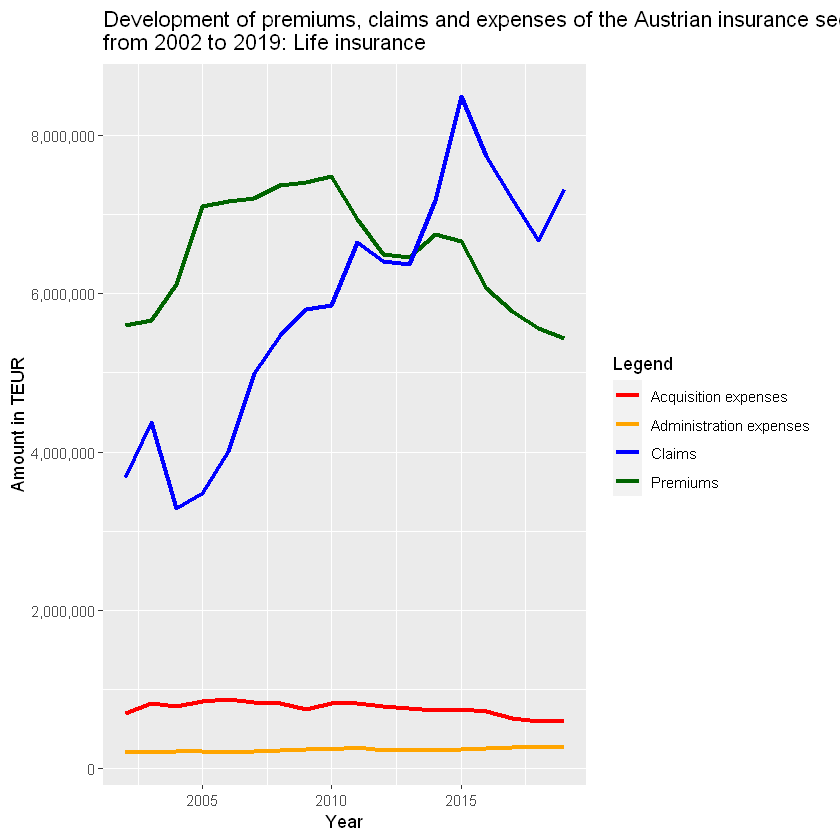

In [6]:
##### PLOT: TIME SERIES OF AUSTRIAN INSURANCE SECTOR #####
# the aim of this analysis is to show how total premiums, claims and expenses (acquisition expenses and administrative expenses) of the Austrian insurance sector developed from 2002 to 2019 for each segment (life, health, non-life)

colors_plot_timeseries <- c("Premiums" = "darkgreen", "Claims" = "blue", "Acquisition expenses" = "red", "Administration expenses" = "orange")

### Life insurance
data_life_timeseries <- data.table(
  year = 2002:2019,
  premiums = rep(0, 18),
  claims = rep(0, 18),
  acquisition_expenses = rep(0, 18),
  admin_expenses = rep(0, 18)
)

for (i in 1:nrow(data_life_timeseries)){
  tmp_var <- get(paste0("data_fma", 2001+i))
  data_life_timeseries$premiums[i] <- sum(tmp_var$`Table 9:  Technical account (Life insurance)`[category == "Earned premiums" & subcategory == "Gross amount"]$value)/1000
  data_life_timeseries$claims[i] <- sum(tmp_var$`Table 9:  Technical account (Life insurance)`[category == "Claims incurred" & subcategory == "Gross amount"]$value)/1000
  data_life_timeseries$acquisition_expenses[i] <- sum(tmp_var$`Table 9:  Technical account (Life insurance)`[category == "Net operating expenses" & subcategory == "Acquisition costs"]$value)/1000
  data_life_timeseries$admin_expenses[i] <- sum(tmp_var$`Table 9:  Technical account (Life insurance)`[category == "Net operating expenses" & subcategory == "Administrative expenses"]$value)/1000
  
  remove(tmp_var)
}


plot_life_timeseries <- ggplot(data = data_life_timeseries, aes(x = year)) +
  ggtitle("Development of premiums, claims and expenses of the Austrian insurance sector \nfrom 2002 to 2019: Life insurance") +
  geom_line(aes(y = premiums, color = "Premiums"), size = 1.2) + 
  geom_line(aes(y = claims, color = "Claims"), size = 1.2) + 
  geom_line(aes(y = acquisition_expenses, color = "Acquisition expenses"), size = 1.2) + 
  geom_line(aes(y = admin_expenses, color = "Administration expenses"), size = 1.2) +
  labs(x = "Year",
       y = "Amount in TEUR",
       color = "Legend") +
  scale_color_manual(values = colors_plot_timeseries) +
  scale_y_continuous(labels = scales::comma)

plot_life_timeseries

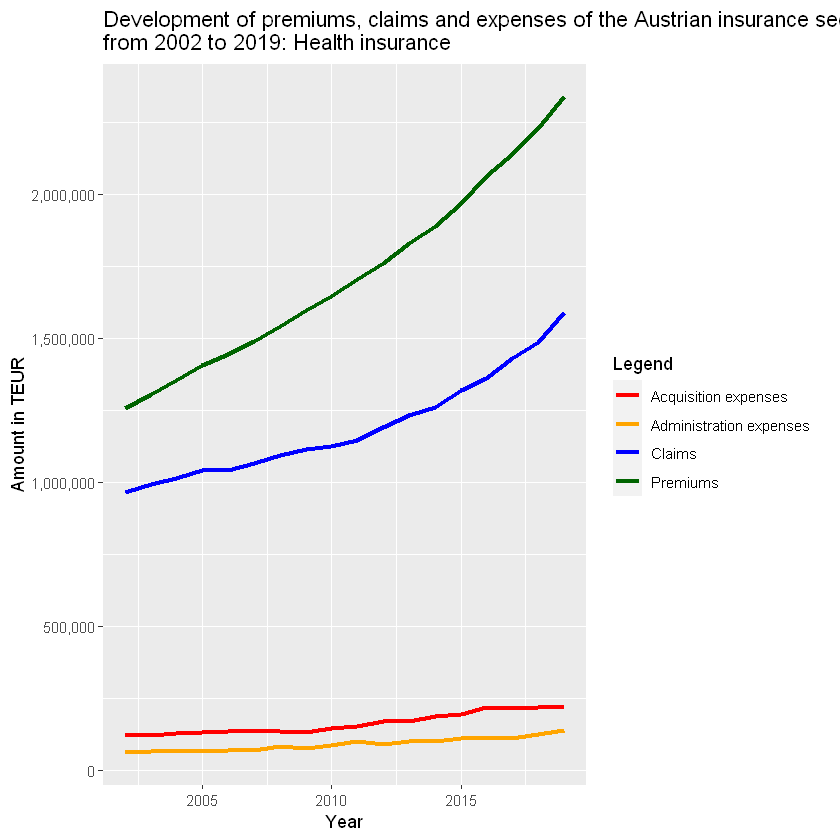

In [7]:
### Health insurance
data_health_timeseries <- data.table(
  year = 2002:2019,
  premiums = rep(0, 18),
  claims = rep(0, 18),
  acquisition_expenses = rep(0, 18),
  admin_expenses = rep(0, 18)
)

for (i in 1:nrow(data_health_timeseries)){
  tmp_var <- get(paste0("data_fma", 2001+i))
  data_health_timeseries$premiums[i] <- sum(tmp_var$`Table 10:  Technical account (Health insurance)`[category == "Earned premiums" & subcategory == "Gross amount"]$value)/1000
  data_health_timeseries$claims[i] <- sum(tmp_var$`Table 10:  Technical account (Health insurance)`[category == "Claims incurred" & subcategory == "Gross amount"]$value)/1000
  data_health_timeseries$acquisition_expenses[i] <- sum(tmp_var$`Table 10:  Technical account (Health insurance)`[category == "Net operating expenses" & subcategory == "Acquisition costs"]$value)/1000
  data_health_timeseries$admin_expenses[i] <- sum(tmp_var$`Table 10:  Technical account (Health insurance)`[category == "Net operating expenses" & subcategory == "Administrative expenses"]$value)/1000
  
  remove(tmp_var)
}

plot_health_timeseries <- ggplot(data = data_health_timeseries, aes(x = year)) +
  ggtitle("Development of premiums, claims and expenses of the Austrian insurance sector \nfrom 2002 to 2019: Health insurance") +
  geom_line(aes(y = premiums, color = "Premiums"), size = 1.2) + 
  geom_line(aes(y = claims, color = "Claims"), size = 1.2) + 
  geom_line(aes(y = acquisition_expenses, color = "Acquisition expenses"), size = 1.2) + 
  geom_line(aes(y = admin_expenses, color = "Administration expenses"), size = 1.2) +
  labs(x = "Year",
       y = "Amount in TEUR",
       color = "Legend") +
  scale_color_manual(values = colors_plot_timeseries) +
  scale_y_continuous(labels = scales::comma)

plot_health_timeseries

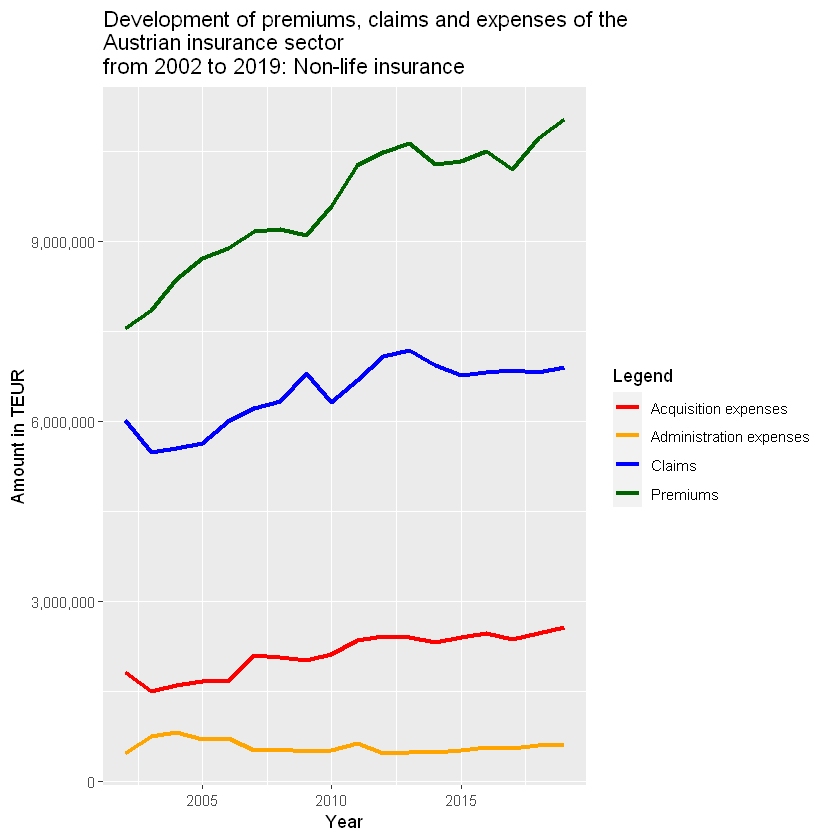

In [8]:
### Non-life insurance
data_nonlife_timeseries <- data.table(
  year = 2002:2019,
  premiums = rep(0, 18),
  claims = rep(0, 18),
  acquisition_expenses = rep(0, 18),
  admin_expenses = rep(0, 18)
)

for (i in 1:nrow(data_nonlife_timeseries)){
  tmp_var <- get(paste0("data_fma", 2001+i))
  data_nonlife_timeseries$premiums[i] <- sum(tmp_var$`Table 11:  Technical account (Non-life insurance other than health)`[category == "Earned premiums" & subcategory == "Gross amount"]$value)/1000
  data_nonlife_timeseries$claims[i] <- sum(tmp_var$`Table 11:  Technical account (Non-life insurance other than health)`[category == "Claims incurred" & subcategory == "Gross amount"]$value)/1000
  data_nonlife_timeseries$acquisition_expenses[i] <- sum(tmp_var$`Table 11:  Technical account (Non-life insurance other than health)`[category == "Net operating expenses" & subcategory == "Acquisition costs"]$value)/1000
  data_nonlife_timeseries$admin_expenses[i] <- sum(tmp_var$`Table 11:  Technical account (Non-life insurance other than health)`[category == "Net operating expenses" & subcategory == "Administrative expenses"]$value)/1000
  
  remove(tmp_var)
}

plot_nonlife_timeseries <- ggplot(data = data_nonlife_timeseries, aes(x = year)) +
  ggtitle("Development of premiums, claims and expenses of the \nAustrian insurance sector \nfrom 2002 to 2019: Non-life insurance") +
  geom_line(aes(y = premiums, color = "Premiums"), size = 1.2) + 
  geom_line(aes(y = claims, color = "Claims"), size = 1.2) + 
  geom_line(aes(y = acquisition_expenses, color = "Acquisition expenses"), size = 1.2) + 
  geom_line(aes(y = admin_expenses, color = "Administration expenses"), size = 1.2) +
  labs(x = "Year",
       y = "Amount in TEUR",
       color = "Legend") +
  scale_color_manual(values = colors_plot_timeseries) +
  scale_y_continuous(labels = scales::comma)

plot_nonlife_timeseries

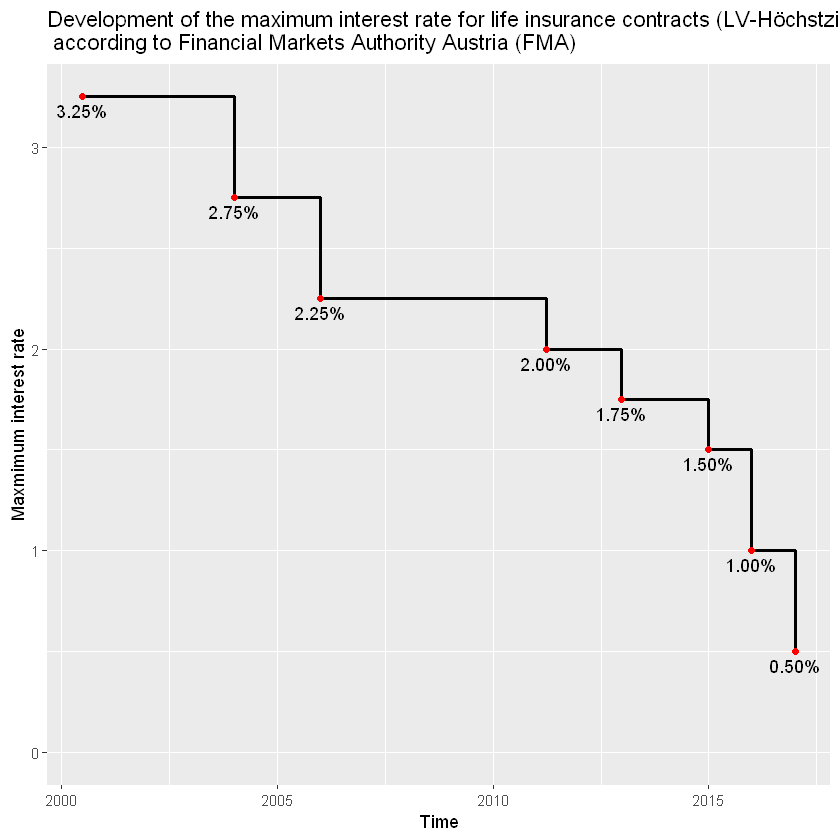

In [9]:
##### PLOT: LV-Höchstzinssatz AUT for comparison with the development of the austrian life insurance sector #####
plot_hzs <- ggplot(data = hzs_aut, aes(x = dates_of_change, y = hzs, label = hzs_char)) +
  geom_step(size = 1) +
  ggtitle("Development of the maximum interest rate for life insurance contracts (LV-Höchstzinssatz)\n according to Financial Markets Authority Austria (FMA)") +
  labs(x = "Time",
       y = "Maxmimum interest rate") +
  geom_point(mapping = aes(x = dates_of_change, y = hzs), color = "red") +
  geom_text(aes(label = hzs_char), hjust = 0.5, vjust = 1.5) +
  expand_limits(y = c(0,3))

plot_hzs

Warning message:
"Continuous limits supplied to discrete scale.
Did you mean `limits = factor(...)` or `scale_*_continuous()`?"

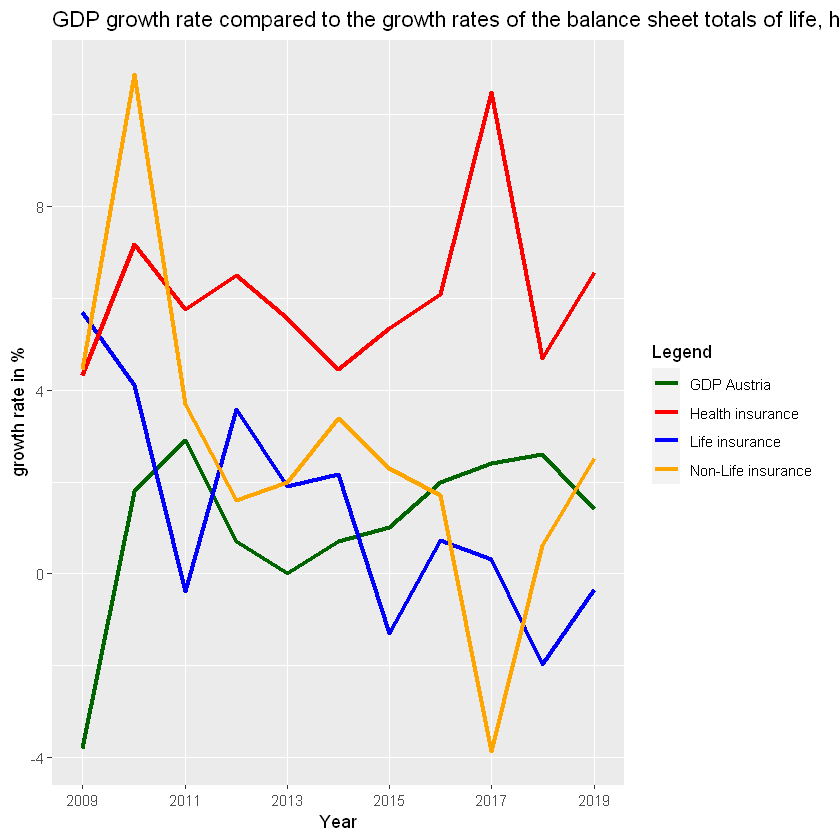

In [10]:
##### PLOT: comparison of growth of the insurance sector with the real GDP growth of EU countries #####
# in this analysis, the growth of the insurance sector in terms of the change in the balance sheet total is compared to the real GDP growth rate of selected EU countries

# Austria
data_growth_aut <- data.table(
  year = c(2008:2019),
  total_assets_life = rep(0,12),
  total_assets_health = rep(0,12),
  total_assets_nonlife = rep(0,12),
  growth_total_assets_life = c(NA,rep(0,11)),
  growth_total_assets_health = c(NA,rep(0,11)),
  growth_total_assets_nonlife = c(NA,rep(0,11)),
  gdp_growth = c(NA,unlist(GDP_eu[Country == "AUSTRIA" & year > 2008 & year < 2020]$gdp_growth))
)

for (i in 1:12){
  tmp_var <- get(paste0("data_fma", 2007+i))
  data_growth_aut$total_assets_life[i] <- sum(tmp_var$`Table 1:  Balance sheet, assets (Life insurance)`[category == "Total assets"]$value)
  data_growth_aut$total_assets_health[i] <- sum(tmp_var$`Table 3:  Balance sheet, assets (Health insurance)`[category == "Total assets"]$value)
  data_growth_aut$total_assets_nonlife[i] <- sum(tmp_var$`Table 5:  Balance sheet, assets (Non-life insurance other than health)`[category == "Total assets"]$value)
}

for (i in 2:12){
  data_growth_aut$growth_total_assets_life[i] <- ((data_growth_aut$total_assets_life[i]/data_growth_aut$total_assets_life[i-1])-1)*100
  data_growth_aut$growth_total_assets_health[i] <- ((data_growth_aut$total_assets_health[i]/data_growth_aut$total_assets_health[i-1])-1)*100
  data_growth_aut$growth_total_assets_nonlife[i] <- ((data_growth_aut$total_assets_nonlife[i]/data_growth_aut$total_assets_nonlife[i-1])-1)*100
}

colors_plot_growth_aut <- c("GDP Austria" = "darkgreen", "Life insurance" = "blue", "Health insurance" = "red", "Non-Life insurance" = "orange")

plot_nonlife_growth_aut <- ggplot(data = data_growth_aut[2:12,], aes(x = year)) +
  ggtitle("GDP growth rate compared to the growth rates of the balance sheet totals of life, health and non-life insurance") +
  geom_line(aes(y = gdp_growth, color = "GDP Austria"), size = 1.2) + 
  geom_line(aes(y = growth_total_assets_life, color = "Life insurance"), size = 1.2) + 
  geom_line(aes(y = growth_total_assets_health, color = "Health insurance"), size = 1.2) + 
  geom_line(aes(y = growth_total_assets_nonlife, color = "Non-Life insurance"), size = 1.2) +
  labs(x = "Year",
       y = "growth rate in %",
       color = "Legend") +
  scale_color_manual(values = colors_plot_growth_aut) +
  scale_y_continuous(labels = scales::comma) +
  scale_x_discrete(limits = c(2009,2011,2013,2015,2017,2019))

plot_nonlife_growth_aut

## insurance industry of selected EU countries

In [11]:
# other EU Countries
# selected countries for analysis: AUSTRIA, BULGARIA, CROATIA, DENMARK, FINLAND, FRANCE, GERMANY, GREECE, ITALY, NORWAY, POLAND, SPAIN, UNITED KINGDOM 
countries_growth <- c("AUSTRIA", "BULGARIA", "CROATIA", "FINLAND", "FRANCE", "GERMANY", "GREECE", "ITALY", "NORWAY", "POLAND", "SPAIN", "UNITED KINGDOM")

data_growth_eu <- data.table(
  country = rep(countries_growth,4),
  year = c(rep(2016,length(countries_growth)), rep(2017,length(countries_growth)), rep(2018,length(countries_growth)), rep(2019,length(countries_growth))),
  total_assets = rep(0, 4*length(countries_growth)),
  growth_total_assets = c(rep(NA, length(countries_growth)), rep(0, 3*length(countries_growth))),
  growth_gdp = c(rep(NA, length(countries_growth)), rep(0, 3*length(countries_growth))),
  premiums_life = c(rep(NA, length(countries_growth)), rep(0, 3*length(countries_growth))),
  premiums_nonlife = rep(0, 4*length(countries_growth)),
  growth_premiums_life = c(rep(NA, 2*length(countries_growth)), rep(0, 2*length(countries_growth))),
  growth_premiums_nonlife = c(rep(NA, length(countries_growth)), rep(0, 3*length(countries_growth)))
)

#gathering data from GDP_eu and eiopa_BS
for (Country_i in countries_growth){
  for (Year_i in c(2016:2019)){
    data_growth_eu[country == Country_i & year == Year_i]$total_assets <- eiopa_BS[Reporting.country == Country_i & Reference.period == Year_i & Item == "Total assets"]$Value
    data_growth_eu[country == Country_i & year == Year_i]$growth_gdp <- GDP_eu[Country == Country_i & year == Year_i]$gdp_growth
    data_growth_eu[country == Country_i & year == Year_i]$premiums_nonlife <- eiopa_premiums[Reporting.country == Country_i & Reference.period == Year_i & Item.code == "R0110"]$Value
    # Premiums for life insurance is only available for the years 2017 - 2019. Therefore, 2016 is skipped.
    if (Year_i != 2016){
      data_growth_eu[country == Country_i & year == Year_i]$premiums_life <- eiopa_premiums[Reporting.country == Country_i & Reference.period == Year_i & Item.code == "R1410"]$Value
    }
  }
}

#calculating growth rates of total assets
for (Country_i in countries_growth){
  for (Year_i in c(2017:2019)){
    data_growth_eu[country == Country_i & year == Year_i]$growth_total_assets <- ((((data_growth_eu[country == Country_i & year == Year_i]$total_assets)/(data_growth_eu[country == Country_i & year == (Year_i-1)]$total_assets))-1)*100)
    data_growth_eu[country == Country_i & year == Year_i]$growth_premiums_nonlife <- ((((data_growth_eu[country == Country_i & year == Year_i]$premiums_nonlife)/(data_growth_eu[country == Country_i & year == (Year_i-1)]$premiums_nonlife))-1)*100)
    if (Year_i != 2017){
      data_growth_eu[country == Country_i & year == Year_i]$growth_premiums_life <- ((((data_growth_eu[country == Country_i & year == Year_i]$premiums_life)/(data_growth_eu[country == Country_i & year == (Year_i-1)]$premiums_life))-1)*100)
    }
  }
}


colors_plot_growth_eu <- c("AUSTRIA" = "darkgreen", "BULGARIA" = "red", "CROATIA" = "green", "FINLAND" = "lightblue", "FRANCE" = "cadetblue1", "GERMANY" = "yellow", "GREECE" = "palegreen", "ITALY" = "orange", "NORWAY" = "darkviolet", "POLAND" = "maroon1", "SPAIN" = "cyan", "UNITED KINGDOM" = "grey")


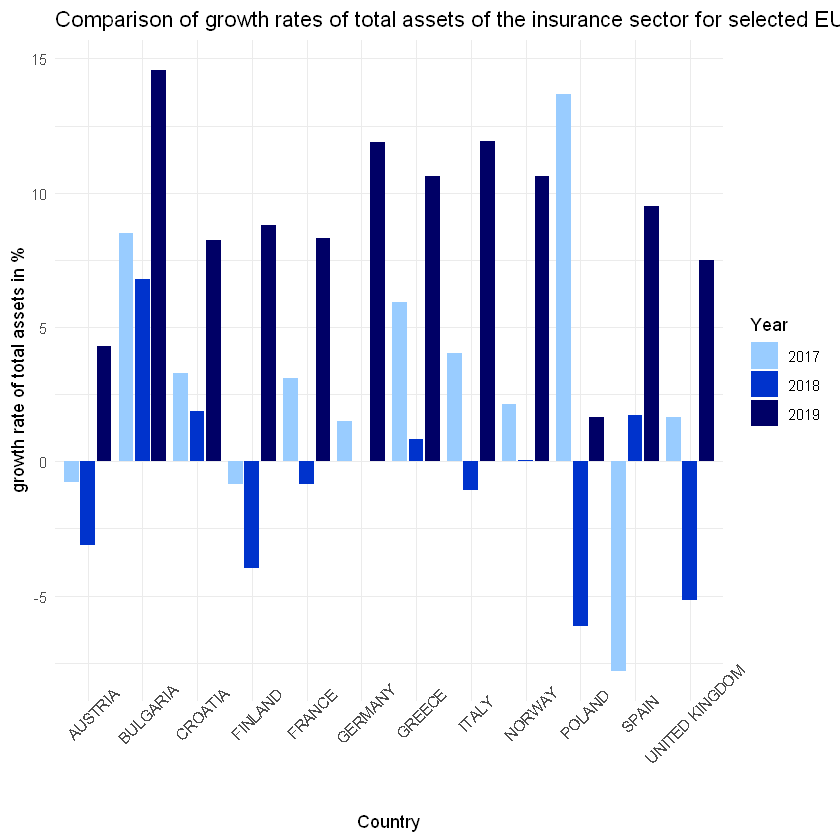

In [12]:
##### PLOT: growth of total assets for the years 2017 - 2019 for selected countries #####
plot_nonlife_growth_assets_eu_bar <- ggplot(data = data_growth_eu[year > 2016], aes(x = country, y = growth_total_assets, fill = factor(year))) +
  ggtitle("Comparison of growth rates of total assets of the insurance sector for selected EU countries") +
  geom_bar(stat = "identity", position = position_dodge2()) +
  labs(x = "Country",
       y = "growth rate of total assets in %") +
  scale_y_continuous(labels = scales::comma) +
  scale_fill_manual(values=c("#99CCFF", "#0033CC", "#000066")) +
  theme_minimal() +
  labs(fill = "Year") +
  theme(axis.text.x = element_text(angle = 45))

plot_nonlife_growth_assets_eu_bar

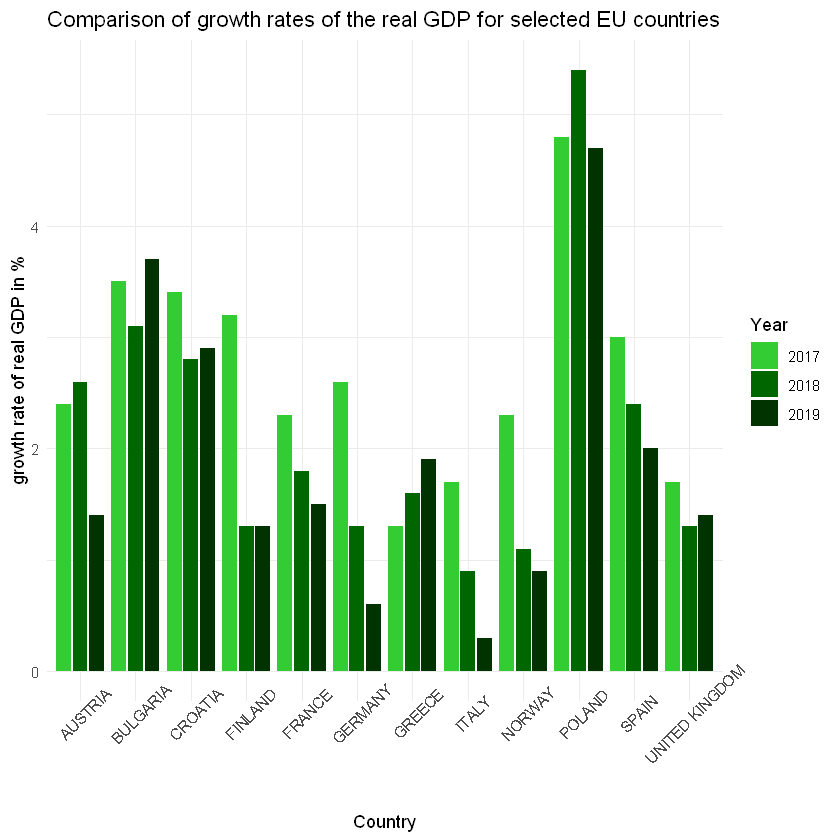

In [13]:
##### PLOT: growth of real GDP for the years 2017 - 2019 for selected countries #####
plot_nonlife_growth_gdp_eu_bar <- ggplot(data = data_growth_eu[year > 2016], aes(x = country, y = growth_gdp, fill = factor(year))) +
  ggtitle("Comparison of growth rates of the real GDP for selected EU countries") +
  geom_bar(stat = "identity", position = position_dodge2()) +
  labs(x = "Country",
       y = "growth rate of real GDP in %") +
  scale_y_continuous(labels = scales::comma) +
  scale_fill_manual(values=c("#33CC33", "#006600", "#003300")) +
  theme_minimal() +
  labs(fill = "Year") +
  theme(axis.text.x = element_text(angle = 45))

plot_nonlife_growth_gdp_eu_bar

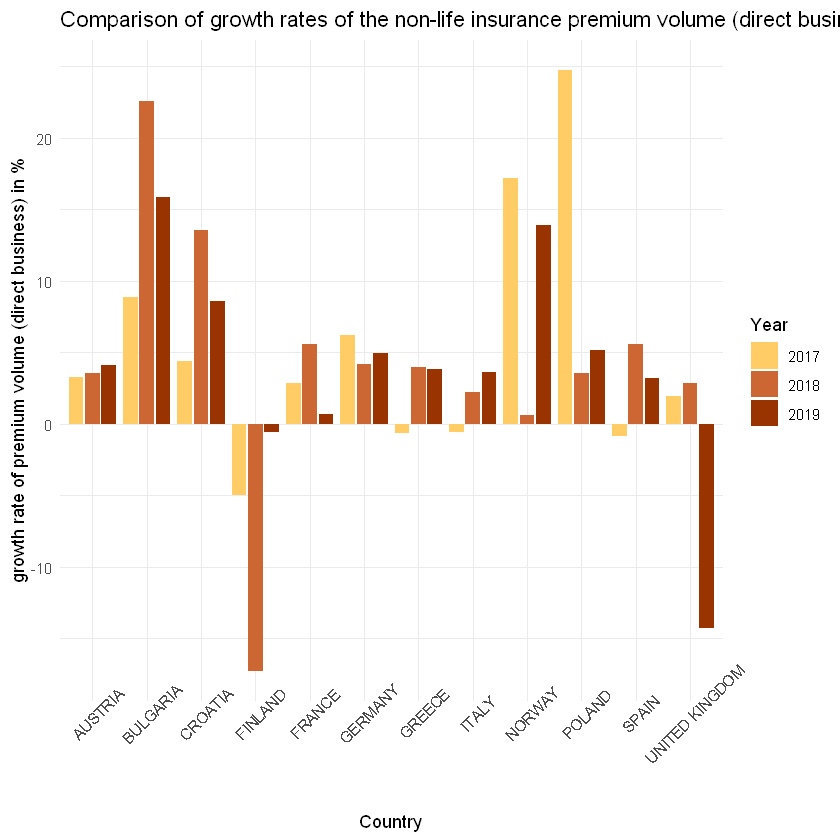

In [14]:
##### PLOT: growth of premium volume for nonlife insurance for the years 2017 - 2019 for selected countries #####
plot_nonlife_growth_nonlife_eu_bar <- ggplot(data = data_growth_eu[year > 2016], aes(x = country, y = growth_premiums_nonlife, fill = factor(year))) +
  ggtitle("Comparison of growth rates of the non-life insurance premium volume (direct business) for selected EU countries") +
  geom_bar(stat = "identity", position = position_dodge2()) +
  labs(x = "Country",
       y = "growth rate of premium volume (direct business) in %") +
  scale_y_continuous(labels = scales::comma) +
  scale_fill_manual(values=c("#FFCC66", "#CC6633", "#993300")) +
  theme_minimal() +
  labs(fill = "Year") +
  theme(axis.text.x = element_text(angle = 45))

plot_nonlife_growth_nonlife_eu_bar

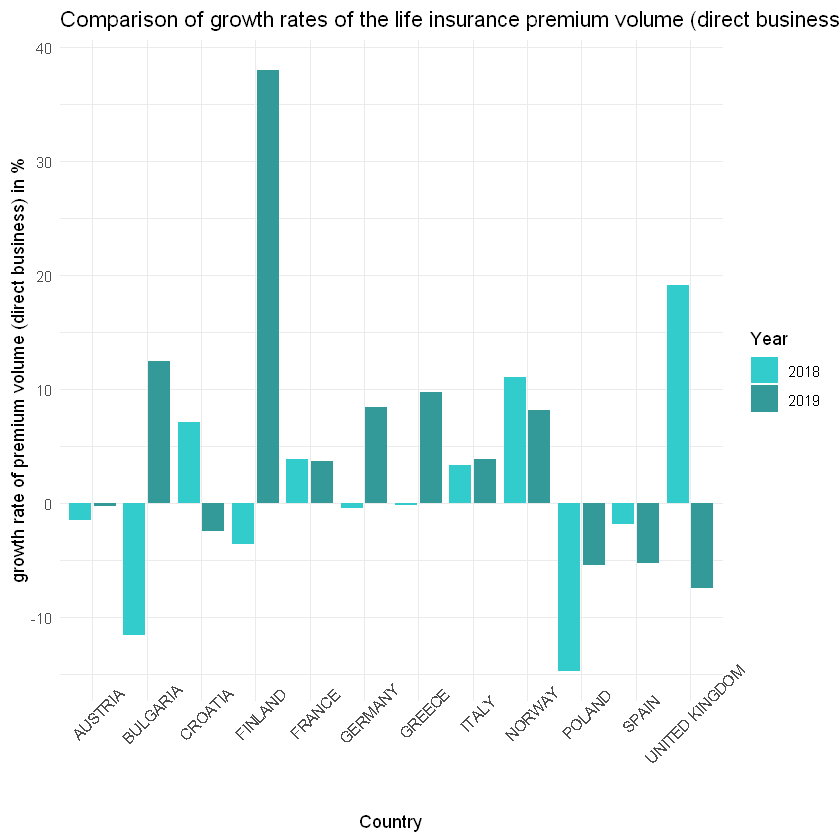

In [15]:
##### PLOT: growth of premium volume for life insurance for the years 2018 - 2019 for selected countries #####
plot_nonlife_growth_life_eu_bar <- ggplot(data = data_growth_eu[year > 2017], aes(x = country, y = growth_premiums_life, fill = factor(year))) +
  ggtitle("Comparison of growth rates of the life insurance premium volume (direct business) for selected EU countries") +
  geom_bar(stat = "identity", position = position_dodge2()) +
  labs(x = "Country",
       y = "growth rate of premium volume (direct business) in %") +
  scale_y_continuous(labels = scales::comma) +
  scale_fill_manual(values=c("#33CCCC", "#339999")) +
  theme_minimal() +
  labs(fill = "Year") +
  theme(axis.text.x = element_text(angle = 45))

plot_nonlife_growth_life_eu_bar